In [1]:
# import useful libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl 
mpl.rcParams["figure.dpi"] = 150
import seaborn as sns
import os

# enable copy on write (default in pandas 3.0)
pd.options.mode.copy_on_write = True

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold

In [3]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC

In [43]:
import joblib

In [4]:
def read_merged(weather, year):
    return pd.read_csv('../merged/merged_{}_{}.csv'.format(weather, year))

In [5]:
meso = [read_merged("meso", year) for year in range(2015, 2023)]

In [6]:
data = pd.concat(meso)
del meso

In [7]:
del data['Unnamed: 0']
del data['index']
data['TVS_max'] = 1*(data['TVS_max'] == 'Y')
data['DATE'] = pd.to_datetime(data['DATE'])
data['Month'] = data['DATE'].dt.month

In [8]:
data['y'] = 0

data.loc[data.power_outage == True, 'y']=1

In [9]:
all_features =([data.columns[1], 
                data.columns[2]] +
                data.columns[4:13].tolist() +
                [data.columns[16]])

In [10]:
all_features

['LAT_mean',
 'LON_mean',
 'LL_ROT_VEL_max',
 'LL_DV_max',
 'LL_BASE_max',
 'DEPTH_KFT_max',
 'DPTH_STMRL_max',
 'MAX_RV_KFT_max',
 'MAX_RV_KTS_max',
 'TVS_max',
 'MSI_max',
 'Month']

In [11]:
meso_train, meso_test = train_test_split(data.copy(),
                                              shuffle=True,
                                              random_state=123,
                                              test_size=.2,
                                              stratify=data.y.values)

In [12]:
meso_tt, meso_val = train_test_split(meso_train.copy(),
                                              shuffle=True,
                                              random_state=123,
                                              test_size=.2,
                                              stratify=meso_train.y.values)

In [13]:
outage = meso_tt[meso_tt['power_outage']==True]
no_outage = meso_tt[meso_tt['power_outage']==False]
no_outage= no_outage.sample(n=len(outage), random_state=101)
meso_tt_balanced = pd.concat([outage,no_outage],axis=0)

In [14]:
n_splits = 5

kfold = StratifiedKFold(n_splits,
                           shuffle=True,
                           random_state=498)

In [15]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB

In [22]:
accs = np.zeros(n_splits)
reccs = np.zeros(n_splits)
precis = np.zeros(n_splits)

for i, (train_index, test_index) in enumerate(kfold.split(meso_tt_balanced, meso_tt_balanced.y)):
    print("CV Split", i)
    meso_bal_tt = meso_tt_balanced.iloc[train_index]
    meso_ho = meso_tt_balanced.iloc[test_index]
    
    ## Quadratic Discriminant Analysis
    qda = Pipeline([('scale', StandardScaler()),
                    ('qda', QuadraticDiscriminantAnalysis())])
    
    qda.fit(meso_bal_tt[all_features].values,
               meso_bal_tt.y.values)
    
    qda_pred = qda.predict(meso_ho[all_features].values)
    
    accs[i] = accuracy_score(meso_ho.y.values,
                                         qda_pred)
    
    reccs[i] = recall_score(meso_ho.y.values,
                                         qda_pred)
    
    precis[i] = precision_score(meso_ho.y.values,
                                         qda_pred)

CV Split 0
CV Split 1
CV Split 2
CV Split 3
CV Split 4


In [23]:
np.mean(accs, axis=0)

0.551635010769532

In [24]:
np.mean(reccs, axis=0)

0.27036746948632595

In [25]:
np.mean(precis, axis=0)

0.6179224385194941

In [27]:
from sklearn.model_selection import GridSearchCV

In [28]:
params = {'reg_param': [0.1, 0.2, 0.3, 0.4, 0.5]}

In [29]:
grid = GridSearchCV(QuadraticDiscriminantAnalysis(), params, refit = True, verbose=15, n_jobs=6,
                          cv = 5)


In [32]:
grid.best_estimator_

QuadraticDiscriminantAnalysis(reg_param=0.5)

In [35]:
model = grid.best_estimator_
model.fit(meso_tt_balanced[all_features], meso_tt_balanced.y)

QuadraticDiscriminantAnalysis(reg_param=0.5)

In [36]:
accuracy_score(meso_tt_balanced.y, model.predict(meso_tt_balanced[all_features]))

0.6166568761830168

In [37]:
recall_score(meso_tt_balanced.y, model.predict(meso_tt_balanced[all_features]))

0.6071862149990209

In [38]:
precision_score(meso_tt_balanced.y, model.predict(meso_tt_balanced[all_features]))

0.6189091731644357

In [39]:
accuracy_score(meso_val.y, model.predict(meso_val[all_features]))

0.6242759394481482

In [40]:
recall_score(meso_val.y, model.predict(meso_val[all_features]))

0.613763934939822

In [41]:
precision_score(meso_val.y, model.predict(meso_val[all_features]))

0.06869035722842634

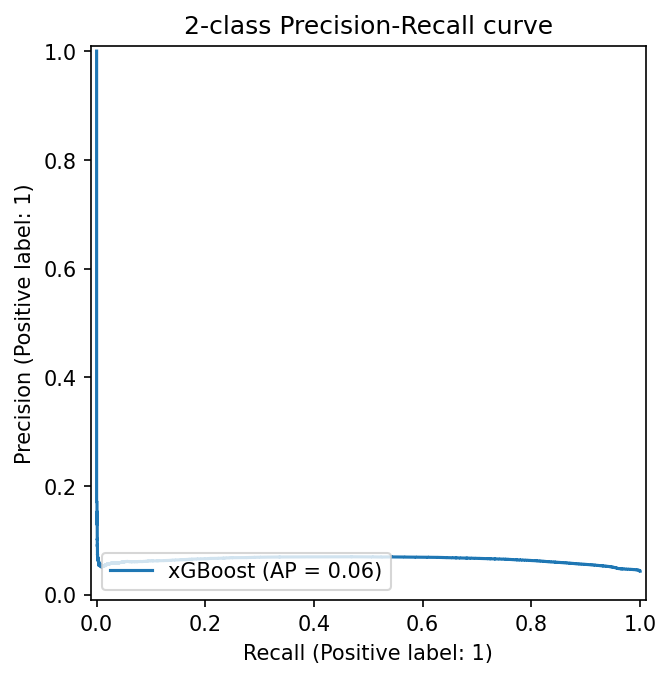

In [42]:
from sklearn.metrics import PrecisionRecallDisplay

display = PrecisionRecallDisplay.from_estimator(
    model, meso_val[all_features], meso_val['power_outage'], name="xGBoost")
_ = display.ax_.set_title("2-class Precision-Recall curve")

In [44]:
joblib.dump(model,'../models/qda_meso.pkl')

['../models/qda_meso.pkl']